# Импорт библиотек

In [1]:
# based on https://www.kaggle.com/konstanter/fasterrcnn-pytorch-maskdetection

import numpy as np 
import pandas as pd 
#import torchvision
#from torchvision import transforms, datasets, models
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
#from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
#import matplotlib.patches as patches
#import albumentations as A
#from albumentations.pytorch.transforms import ToTensorV2
import cv2
import os
#import glob
import xml.etree.ElementTree as et
import torchmetrics
#import statistics
import seaborn as sns
from functions import *
import shutil
from PIL import Image as pilim, ImageDraw
from distutils.dir_util import copy_tree
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


# Загрузка данных в DataLoader

In [2]:
os.chdir('/home/ss/Documents/ds/git/MedMask_detection')

# путь к файлам
#images_dir = './data/images/'
#annotations_dir = './data/annotations/'
images_dir = '/home/ss/Documents/ds/git/MedMask_detection/data/images/'
annotations_dir = '/home/ss/Documents/ds/git/MedMask_detection/data/annotations/'


class FaceMaskDataset(torch.utils.data.Dataset):

    def __init__(self, images_dir, annotation_dir,width, height, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annotation_dir = annotation_dir
        self.height = height
        self.width = width
        
        # сортировка изображений
        self.imgs = [image for image in sorted(os.listdir(images_dir))]
        self.annotate = [image for image in sorted(os.listdir(annotation_dir))]
        
        # на 0й позиции находится фон
        self.classes = [_, 'without_mask','with_mask','mask_weared_incorrect']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)

        # изменение цвета и размера изображения    
        img = cv2.imread(image_path) #HWC
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # нормализация изображения
        img_res /= 255.0
        
        # аннотация
        annot_filename = self.annotate[idx]
        annot_file_path = os.path.join(self.annotation_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # высота и ширина изобрадения
        wt = img.shape[1]
        ht = img.shape[0]
        
        # ограничивающие рамки
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
                        
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            # correct anomalies when xmax > width or ymax > height
            if xmax_corr > self.width:
                xmax_corr = self.width
            if ymax_corr > self.height:
                ymax_corr = self.height    
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # перевод boxes в формат torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        #target["image_name"] = img_name


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target, img_name

    def __len__(self):
        return len(self.imgs)


# проверка датасета
dataset = FaceMaskDataset(images_dir, annotations_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

img, target, _ = dataset[35]
print('Image shape = ', img.shape, '\n','Target - ', target)

length of dataset =  853 

Image shape =  (224, 224, 3) 
 Target -  {'boxes': tensor([[ 15.6800,  53.5221,  24.6400,  70.3717],
        [ 54.8800,  61.4513,  63.8400,  79.2920],
        [ 90.7200,  50.5487, 108.6400,  88.2124],
        [164.0800,  59.4690, 175.2800,  80.2832],
        [197.1200,  52.5310, 208.8800,  70.3717],
        [128.2400,  52.5310, 134.9600,  71.3628]]), 'labels': tensor([2, 2, 3, 2, 2, 2]), 'area': tensor([150.9720, 159.8527, 674.9337, 233.1186, 209.8069, 126.5501]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0]), 'image_id': tensor([35])}


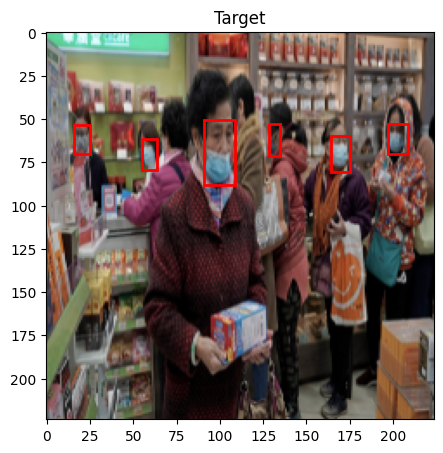

In [3]:
img, target, _ = dataset[35]

plot_img_bbox(img, [target]);

In [4]:
dataset = FaceMaskDataset(images_dir, annotations_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = FaceMaskDataset(images_dir, annotations_dir, 480, 480, transforms= get_transform(train=False))

# разделим данные на train и test
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

# Обучение модели
We're going to use fasterrcnn_resnet50_fpn.

The model has 4 children: transform, backbone, rpn, roi_heads. Transform deals with input normalization. Backbone is a Resnet-50 architecture along with feature pyramid network. Region Proposal network (rpn) generates candidate proposals for Region of Interest network (roi_heads).

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 4

In [6]:
--

SyntaxError: invalid syntax (3659366440.py, line 1)

In [ ]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#num_classes = 4

model = get_model_instance_segmentation(num_classes)

num_epochs = 5

model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()         
        epoch_loss += losses.item()

    model.eval()
    metric = torchmetrics.Accuracy(task='multiclass', num_classes=3)
    with torch.no_grade():
        for images, annotations in data_loader_test:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        
            trues = targets['labels']
            predict = model(images, annotations)[0]['labels']

            acc = metric(predict, trues)  
        acc = metric.compute()
        metric.reset()
    print('Epoch_loss = ',epoch_loss)


In [ ]:
model = get_model_instance_segmentation(num_classes)
model.load_state_dict(torch.load('data/res.pt', map_location=torch.device('cpu')))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### NMS
Performs non-maximum suppression (NMS) on the boxes according to their intersection-over-union (IoU).

NMS iteratively removes lower scoring boxes which have an IoU greater than iou_threshold with another (higher scoring) box.

If multiple boxes have the exact same score and satisfy the IoU criterion with respect to a reference box, the selected box is not guaranteed to be the same between CPU and GPU. This is similar to the behavior of argsort in PyTorch when repeated values are present.

In [ ]:
img, target, _ = dataset_test[1]

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))
#prediction

predicted #boxes:  12
real #boxes:  9


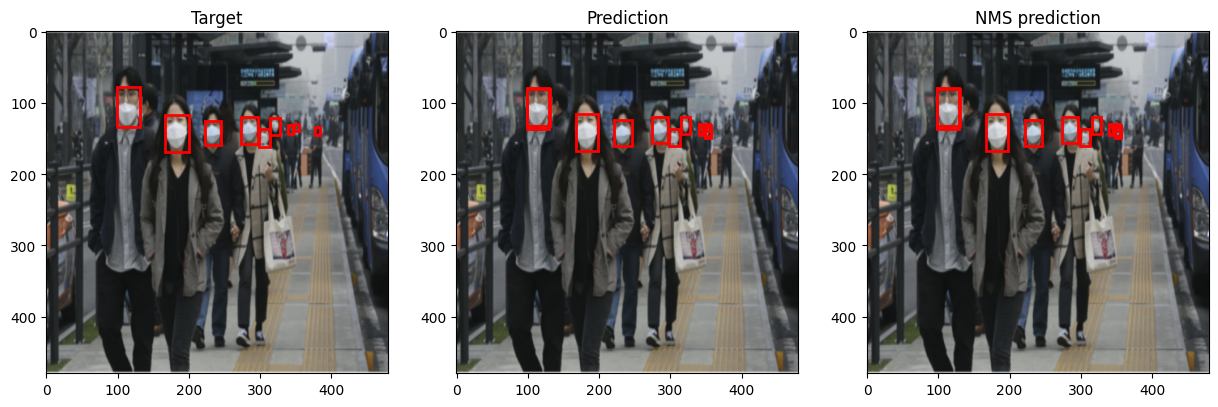

In [ ]:
plot_img_bbox(torch_to_pil(img), [target, prediction, apply_nms(prediction, iou_thresh=0.95)])

In [ ]:
#print('EXPECTED OUTPUT')
#plot_img_bbox(torch_to_pil(img), target)

In [ ]:
#print('MODEL OUTPUT')
#plot_img_bbox(torch_to_pil(img), prediction)

In [ ]:
#nms_prediction = apply_nms(prediction, iou_thresh=0.95)
#print('NMS APPLIED MODEL OUTPUT')
#plot_img_bbox(torch_to_pil(img), nms_prediction)

# Отрисовка изображений

In [ ]:
i = 0
for imgs, annotations, _ in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        if i == 3:
                break

In [ ]:
model.eval()
with torch.no_grad():
    preds = model(imgs)

#preds

Prediction


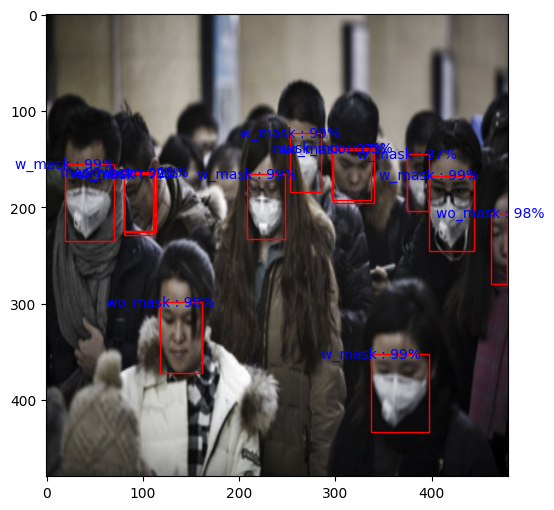

In [ ]:
print("Prediction")
plot_image(imgs[3], preds[3])

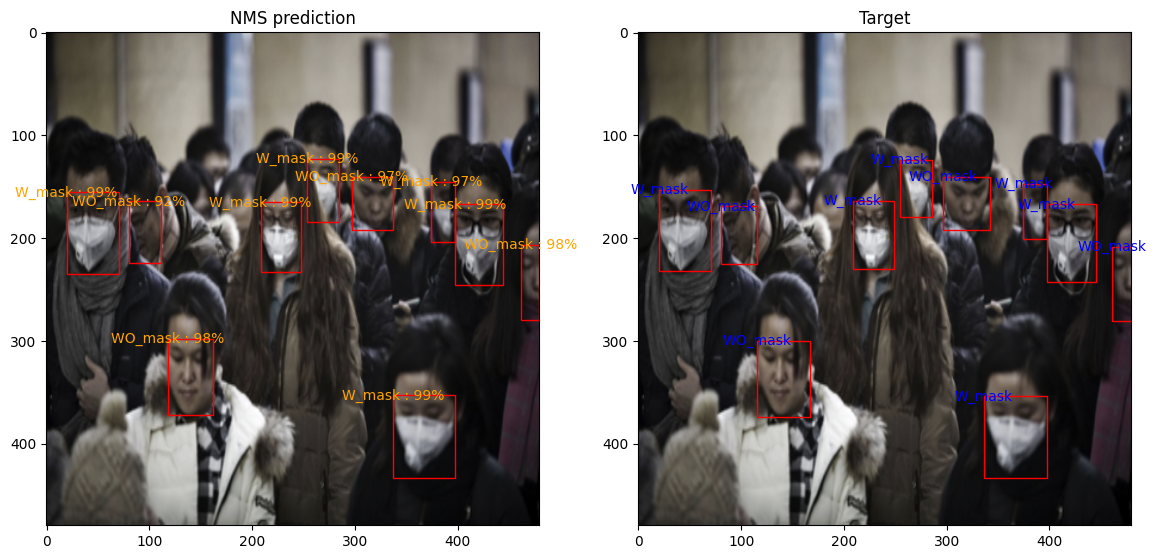

In [ ]:
ids = 3
nms_prediction = apply_nms(preds[ids], iou_thresh=0.2)

plot_image_2(imgs[ids], [nms_prediction, annotations[ids]])

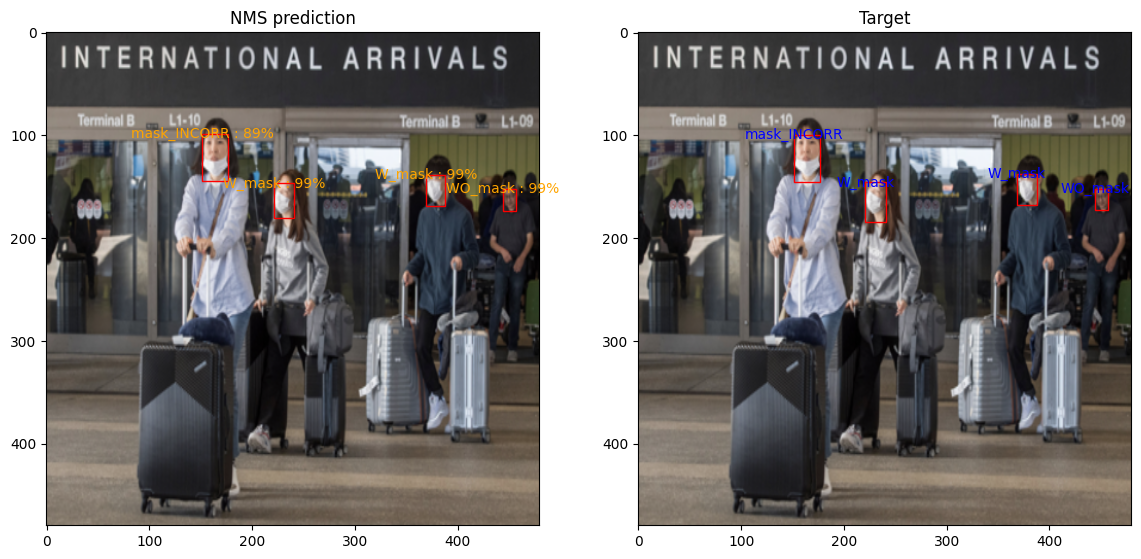

In [ ]:
ids = 6
nms_prediction = apply_nms(preds[ids], iou_thresh=0.2)

plot_image_2(imgs[ids], [nms_prediction, annotations[ids]])


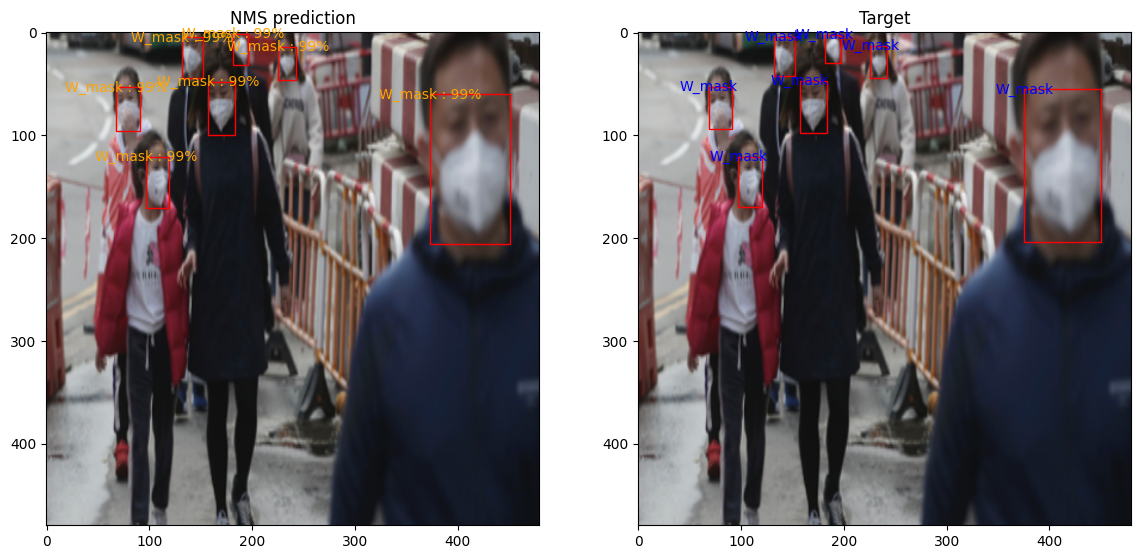

In [ ]:
ids = 0
nms_prediction = apply_nms(preds[ids], iou_thresh=0.2)

plot_image_2(imgs[ids], [nms_prediction, annotations[ids]])

### Model evaluation

In [ ]:
thresholds = np.arange(0.5, 1.05, 0.05).round(2)
df = pd.DataFrame()

model.eval()
with torch.no_grad():
    for ims, ans, _ in data_loader_test:
        ims = list(image.to(device) for image in ims)
        ans = [{k: v.to(device) for k, v in a.items()} for a in ans]
        
        for t,p in zip(ans, model(ims)):
            for threshold in thresholds:#np.arange(0.5, 1.05, 0.05):
                df = get_scores2(df, t, p, threshold)
                #df = pd.concat([df,pd.DataFrame(new_entry)], axis=0, ignore_index=True)
        
    print(df.shape)            


df[df['threshold']==0.75].head(3)

(15048, 8)


TP  FP  label  threshold  GT     score   id       iou
65   0   1      1       0.75   0  0.120711  204  0.000000
66   1   0      2       0.75   8  0.997145  204  0.834107
67   1   0      2       0.75   8  0.995263  204  0.885770

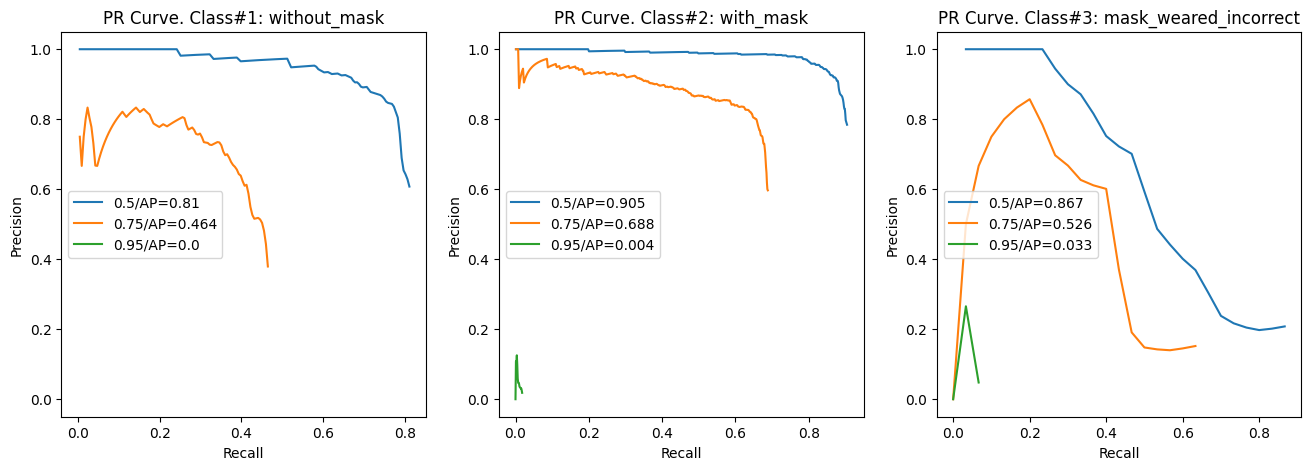

mAP50 = 0.8606


In [ ]:
classes_unique = sorted(df['label'].unique())
classes_decoder = dataset.__dict__['dataset'].__dict__['classes']

f,a = plt.subplots(1,len(classes_unique),figsize=(16,5))
mAP = []
for n,label in enumerate(classes_unique):
    aps = []
    for threshold in [0.5, 0.75, 0.95]:
        dfs = df[(df['threshold']==threshold) & (df['label']==label)].sort_values(['score'], ascending=False)
        dfs['cum TP'] = dfs['TP'].cumsum()
        dfs['cum FP'] = dfs['FP'].cumsum()
        dfs['precision'] = dfs['cum TP'] / (dfs['cum TP'] + dfs['cum FP'])
        GT = dfs.groupby('id')['GT'].mean().sum()
        dfs['recall'] = dfs['cum TP'] / GT
    
        AP = get_AP(dfs['precision'].values, dfs['recall'].values)
        
        sns.lineplot(data=dfs, x='recall', y='precision', label = f"{threshold}/AP={round(AP,3)}", ax=a[n], errorbar=None).set(
            xlabel='Recall', 
            ylabel='Precision', 
            title=f'PR Curve. Class#{label}: {classes_decoder[label]}')
        a[n].legend(loc='center left')

        aps.append(AP)

    class_AP = round(np.mean(aps),3)
    mAP.append(aps[0])
    #a[n].text(0.1,0.8, f'AP_cl{label}={class_AP}', fontsize=14, color='red')
plt.show()

print(f"mAP50 = {round(np.mean(mAP),4)}")

## YOLOV5

In [ ]:
im_path = 'data/'

for i in ["train", "valid"]:
    if not os.path.exists(im_path + i):
        os.mkdir(im_path + i)
    else:
        shutil.rmtree((im_path + i))
        os.mkdir(im_path + i)
    os.mkdir(im_path + i + '/images')
    os.mkdir(im_path + i + '/labels')

In [ ]:
for i, a, im_name in data_loader_test:
    break

print(i[0].shape)
print(a[0])
print(im_name)

torch.Size([3, 480, 480])
{'boxes': tensor([[210.0000,  98.8764, 258.0000, 167.1910],
        [  9.6000, 303.8202,  87.6000, 451.2360],
        [152.4000, 332.5843, 213.6000, 422.4719],
        [318.0000, 332.5843, 348.0000, 406.2921],
        [384.0000, 357.7528, 439.2000, 467.4157],
        [318.0000, 285.8427, 336.0000, 318.2022],
        [390.0000, 257.0786, 410.4000, 278.6517],
        [394.8000, 303.8202, 420.0000, 346.9663],
        [379.2000, 262.4719, 390.0000, 284.0450]]), 'labels': tensor([2, 2, 2, 2, 2, 2, 2, 3, 2]), 'area': tensor([ 3279.1011, 11498.4277,  5501.1260,  2211.2366,  6053.3950,   582.4720,
          440.0897,  1087.2811,   232.9884]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]), 'image_id': tensor([204])}
('maksssksksss282.png', 'maksssksksss386.png', 'maksssksksss832.png', 'maksssksksss662.png', 'maksssksksss563.png', 'maksssksksss449.png', 'maksssksksss175.png', 'maksssksksss824.png', 'maksssksksss558.png', 'maksssksksss86.png')


In [ ]:
def convert_to_yolov(data_loader, tofolder='train'):

    img_objects = dict()
    # for each object
    for ims, ans, names in data_loader:
        for im,an,name in zip(ims,ans, names):
            img_objects[name] = []
            
            for num in range(len(an['labels'])):
                box = an['boxes'][num] 
                class_id = an['labels'][num].item()

                X = ((box[0] + box[2]) / 2).item()
                Y = ((box[1] + box[3]) / 2).item()
                Width = (box[2] - box[0]).item()
                Height = (box[3] - box[1]).item()
                #print(X,Y,Width, Height)
                # normalization
                img_shape = im.shape
                #print(img_shape)
                image_c, image_w, image_h = img_shape[0], img_shape[1], img_shape[2]
                #print(image_c, image_w, image_h)
                X /= image_w
                Y /= image_h
                Width /= image_w
                Height /= image_h

                img_objects[name].append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, X, Y, Width, Height))
        
    #return img_objects

    #print(img_objects)
    for key in img_objects.keys():
        # naming a file
        save_file_name = os.path.join(f"data/{tofolder}/labels/", key.replace("png","txt"))
        #print(save_file_name)
        # save the file on hdd
        print("\n".join(img_objects[key]), file= open(save_file_name, "w"))
        shutil.copy(f"data/images/{key}", f"data/{tofolder}/images/{key}")
        

#%cd /content
# generate annotation files
#convert_to_yolov5(xml_df, unique_img_names)

convert_to_yolov(data_loader, 'train')
convert_to_yolov(data_loader_test, 'valid')


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


In [ ]:
print(f"TRAIN images: {len(os.listdir('data/train/images'))}")
print(f"TRAIN annotations: {len(os.listdir('data/train/labels'))}")

print(f"VALID images: {len(os.listdir('data/valid/images'))}")
print(f"VALID annotations: {len(os.listdir('data/valid/labels'))}")

TRAIN images: 683
TRAIN annotations: 683
VALID images: 170
VALID annotations: 170


In [ ]:
copy_tree("data/train/", '/home/ss/Documents/ds/git/SF_2/yolov5/datasets/mask/train/')
copy_tree("data/valid/", '/home/ss/Documents/ds/git/SF_2/yolov5/datasets/mask/valid')

random annotation: ['data/train/labels/maksssksksss85.txt']
267 400 2.0 83.97150000000002 54.000000000000014 199.04850000000002 166.8


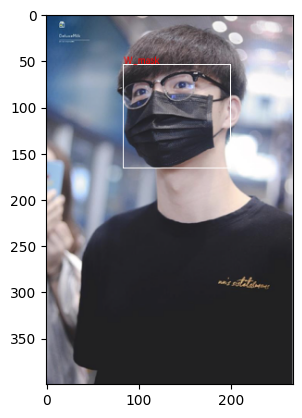

In [ ]:
annotation_random = !ls data/train/labels/*txt | shuf -n 1
#annotation_random = ['data/train/labels/maksssksksss263.txt']
print(f"random annotation: {annotation_random}")

annotation_file = annotation_random[0]
with open(annotation_file, "r") as file:
    ann_list = file.read().split("\n")[:-1]
    #print(annotation_list)
    ann_list = [x.split(" ") for x in ann_list]
    ann_list = [[float(y) for y in x ] for x in ann_list]
    #print(annotation_list)

#Get the corresponding image file
im_file = annotation_file.replace("txt", "png").replace("labels", "images")
#print(image_file)
assert os.path.exists(im_file)

#Load the image
im = pilim.open(im_file)

#Plot the Bounding Box
plot_bounding_box(im, ann_list)

In [ ]:
os.chdir('/home/ss/Documents/ds/git/SF_2/yolov5')
!pwd

/home/ss/Documents/ds/git/SF_2/yolov5


In [ ]:
!python3 detect.py --weights yolov5s.pt --img 480 --conf 0.25 --source data/images/masks

detect: weights=['yolov5s.pt'], source=data/images/masks, data=data/coco128.yaml, imgsz=[480, 480], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-350-g6096750f Python-3.10.12 torch-2.4.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/11 /home/ss/Documents/ds/git/SF_2/yolov5/data/images/masks/1.jpg: 480x480 1 person, 69.4ms
image 2/11 /home/ss/Documents/ds/git/SF_2/yolov5/data/images/masks/11.jpg: 480x480 1 person, 62.4ms
image 3/11 /home/ss/Documents/ds/git/SF_2/yolov5/data/images/masks/111.png: 320x480 11 persons, 55.6ms
image 4/11 /home/ss/Documents/ds/git/SF_2/yolov5/data/images/masks/2.jp

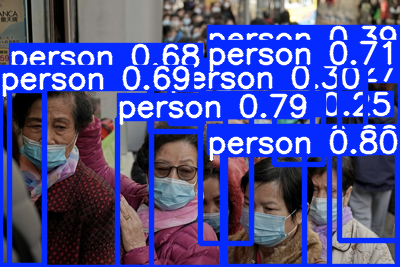

In [ ]:
Image(filename='./runs/detect/exp13/111.png', width=500)
#pilim.open('./runs/detect/exp13/111.jpg')

In [ ]:
!python3 train.py --img 480 --batch 4 --epochs 20 --data data/mask.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache

train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=data/mask.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=4, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: ⚠️ YOLOv5 is out of date by 3 commits. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5 🚀 v7.0-350-g6096750f Python-3.10.12 torch-2.4.0+cu121 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup

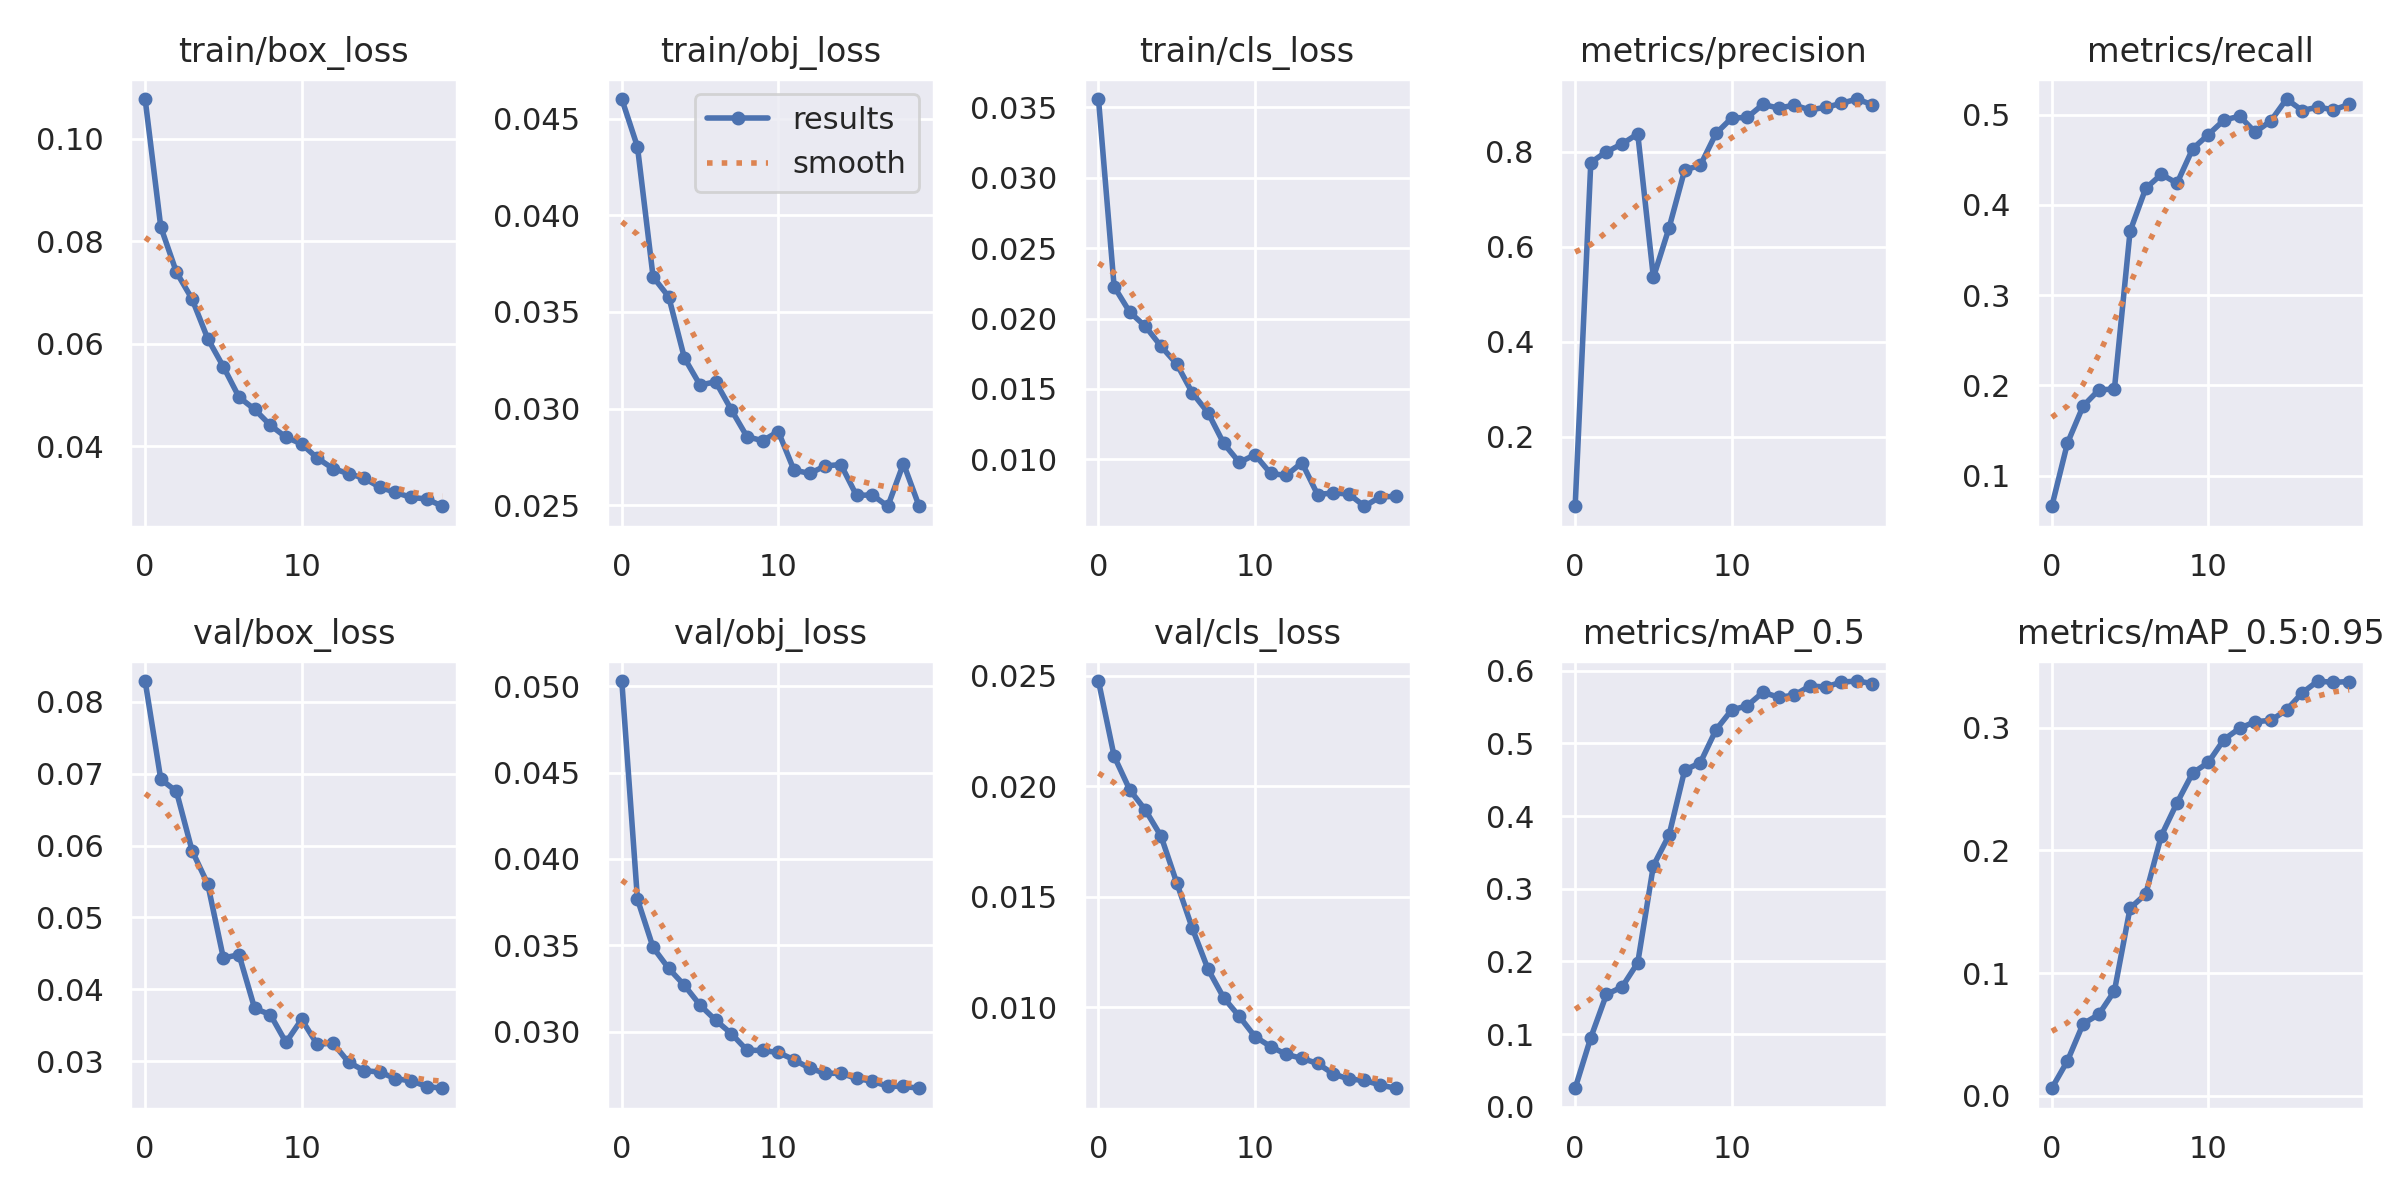

In [ ]:
Image(filename='runs/train/yolov5s_results4/results.png')

In [ ]:
!python3 detect.py --weights runs/train/yolov5s_results4/weights/best.pt --img 480 --conf 0.4 --source data/images/masks

detect: weights=['runs/train/yolov5s_results4/weights/best.pt'], source=data/images/masks, data=data/coco128.yaml, imgsz=[480, 480], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-350-g6096750f Python-3.10.12 torch-2.4.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/10 /home/ss/Documents/ds/git/SF_2/yolov5/data/images/masks/1.jpg: 480x480 1 WO_mask, 73.4ms
image 2/10 /home/ss/Documents/ds/git/SF_2/yolov5/data/images/masks/11.jpg: 480x480 (no detections), 61.8ms
image 3/10 /home/ss/Documents/ds/git/SF_2/yolov5/data/images/masks/2.jpg: 480x480 (no detections), 52.6ms
image 4/10 /home/ss/Document

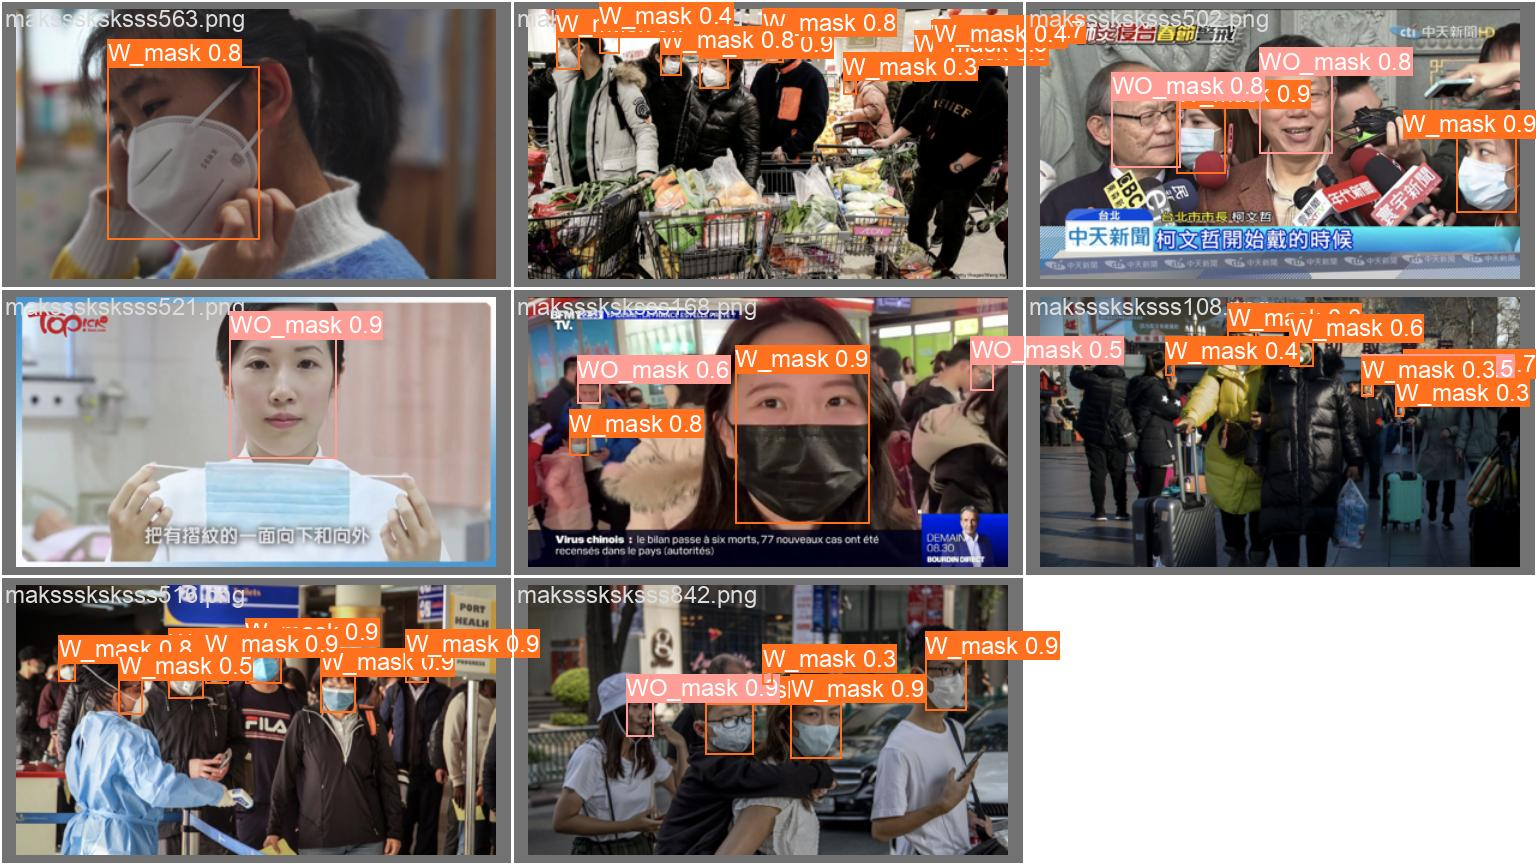

In [ ]:
Image(filename='./runs/train/yolov5s_results4/val_batch2_pred.jpg', width=1000)

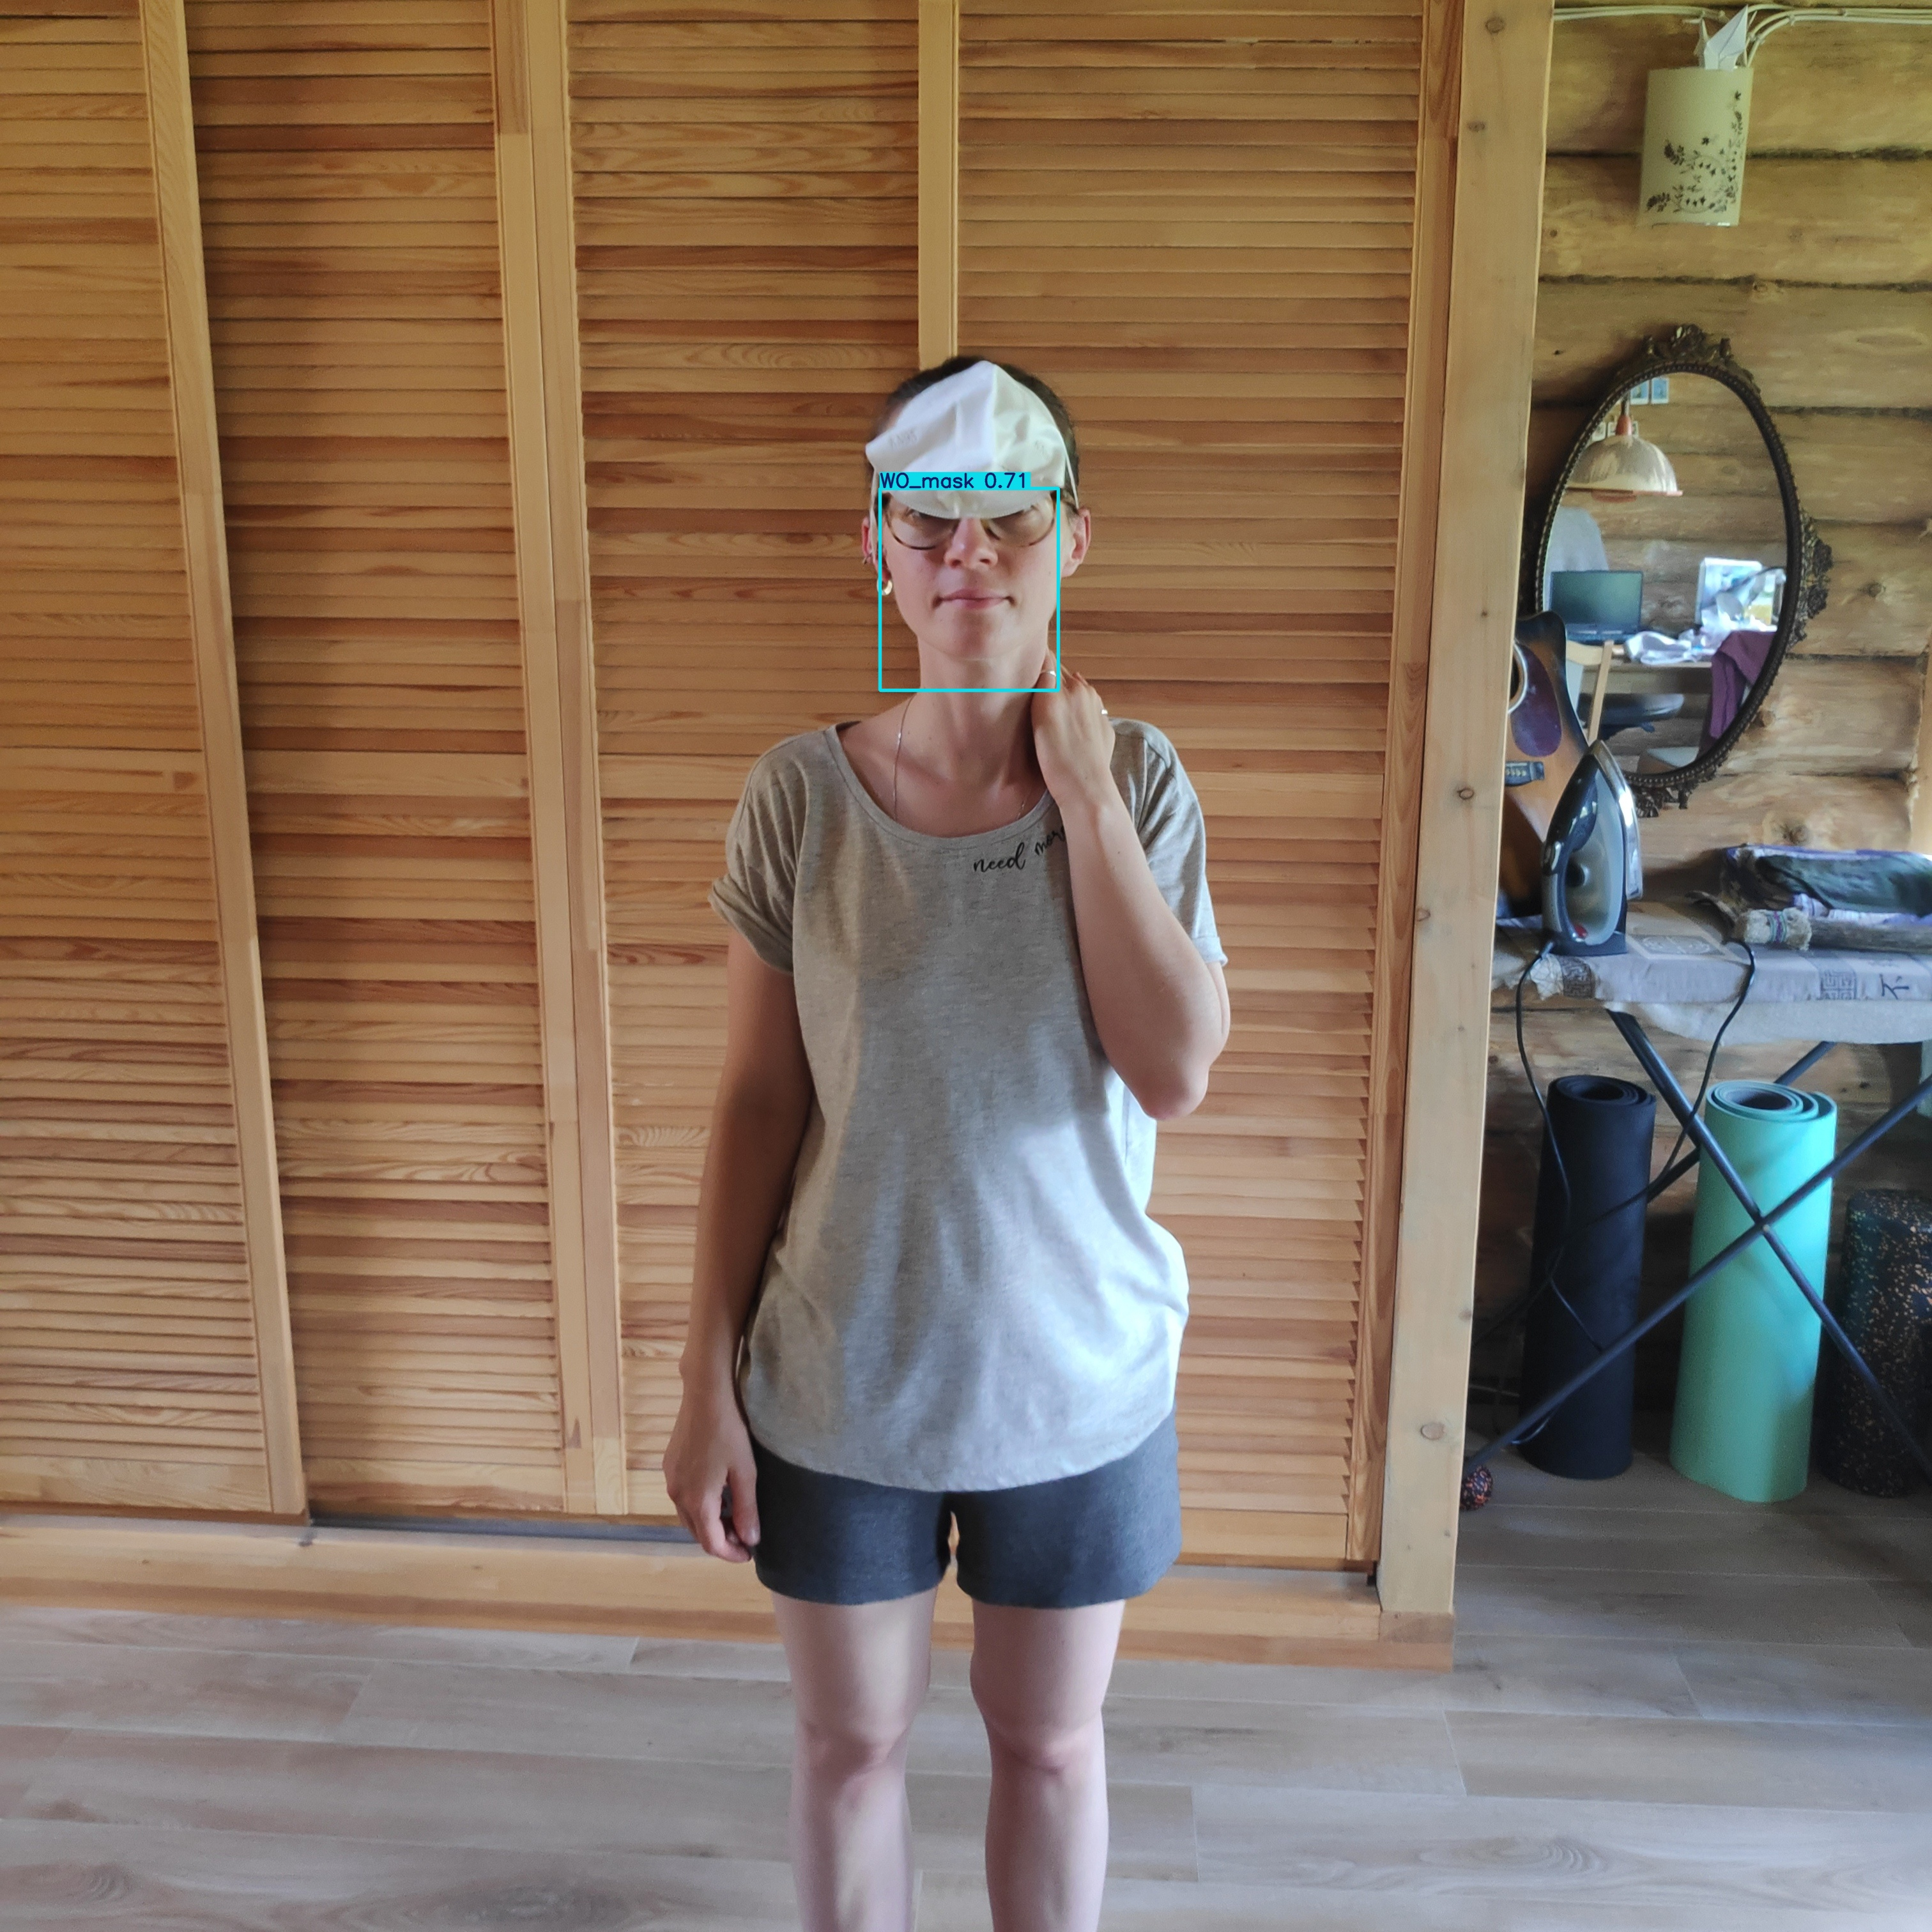

In [ ]:
Image(filename='./runs/detect/exp11/1.jpg', width=700)

In [ ]:
!pwd

/home/ss/Documents/ds/git/MedMask_detection


In [15]:
def get_yolo(path1, path2):
    b = plt.get_backend()
    model = torch.hub.load(path1, 'custom', path1+path2, source='local')
    matplotlib.use(b)
    return model

In [16]:
#os.chdir('/home/ss/Documents/ds/git/SF_2/yolov5')
path_to_yolov = '/home/ss/Documents/ds/git/SF_2/yolov5'
path_to_bestpt = '/runs/train/yolov5s_results4/weights/best.pt'
args = list([path_to_yolov, 'custom', path_to_yolov+path_to_bestpt])
# Model
model = get_yolo(path_to_yolov, path_to_bestpt)
#yolov5 = torch.hub.load(path_to_yolov5, 'custom', path_to_yolov5+path_to_bestpt, source='local')  # custom trained model
model = model.to(device)
# Images
pict = '/home/ss/Documents/ds/git/SF_2/yolov5/data/images/masks/111.png'  # or file, Path, URL, PIL, OpenCV, numpy, list

# Inference
results = model(pict)

# Results
results.print()  # or .show(), .save(), .crop(), .pandas(), etc.

results.xyxy[0]  # im predictions (tensor)
results.pandas().xyxy[0]  # im predictions (pandas)

YOLOv5 🚀 v7.0-350-g6096750f Python-3.10.12 torch-2.4.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
image 1/1: 267x400 1 WO_mask, 26 W_masks
Speed: 15.8ms pre-process, 80.6ms inference, 0.8ms NMS per image at shape (1, 3, 448, 640)


xmin        ymin        xmax        ymax  confidence  class     name
0   248.172012  108.515144  274.961456  138.854523    0.892227      2   W_mask
1   196.473557   90.225723  213.727661  112.371414    0.888191      2   W_mask
2   311.021027  182.494186  345.343781  224.030060    0.882411      2   W_mask
3   148.373367  157.878433  197.319489  209.365677    0.881400      2   W_mask
4   243.014786  195.226730  292.373779  246.305832    0.881139      2   W_mask
5   231.742661   50.778198  245.177383   67.210129    0.869267      2   W_mask
6   276.216248  100.563713  300.528015  126.702881    0.858594      2   W_mask
7   206.648712   46.179520  221.885559   63.072914    0.857518      2   W_mask
8   251.194016   30.596819  266.692444   47.242477    0.846801      2   W_mask
9   225.312195   34.714283  237.242126   48.593620    0.836933      2   W_mask
10  178.381714  105.350952  201.636185  127.124687    0.830987      2   W_mask
11  213.702759   77.664375  234.383789   98.030769    0.814097      2   W_mask
12  264.981842   44.500469  279.170380   59.654869    0.811052      2   W_mask
13  289.721008   28.162827  301.748566   41.417995    0.790729      2   W_mask
14  200.455719  192.508224  230.020203  234.477478    0.745898      2   W_mask
15   19.637625  112.340652   75.142494  172.367996    0.709340      2   W_mask
16  347.210602   32.847164  357.218842   44.664310    0.706961      2   W_mask
17  216.671936   31.108274  224.235611   40.795765    0.698261      2   W_mask
18  224.903641   22.609396  233.623611   32.046886    0.644924      2   W_mask
19  188.951675   69.184967  205.988312   83.624878    0.616834      2   W_mask
20  248.824692   80.287979  267.553986   94.795654    0.589790      2   W_mask
21  360.581696   30.186310  369.059418   38.685310    0.498128      2   W_mask
22  182.340805   15.264882  190.447952   25.327801    0.390661      2   W_mask
23  206.055511   84.053192  229.885468  106.511360    0.343534      2   W_mask
24  378.494415   73.714462  394.615082   95.031754    0.315768      1  WO_mask
25  191.682236   30.159950  199.624939   38.205040    0.308221      2   W_mask
26  197.159897   45.054928  205.986191   56.033653    0.266619      2   W_mask

In [18]:
#os.chdir('/home/ss/Documents/ds/git/MedMask_detection')
!pwd

/home/ss/Documents/ds/git/MedMask_detection


In [19]:
thresholds = np.arange(0.5, 1.05, 0.05).round(2)
df = pd.DataFrame()

model.eval()
with torch.no_grad():
    for ims, ans, _ in data_loader_test:
        #ims = list(image.to(device) for image in ims)
        ims = list(image.to(device) for image in ims)
        ans = [{k: v.to(device) for k, v in an.items()} for an in ans]
        
        for t,i in zip(ans, ims):
            p = model(np.moveaxis(i.cpu().numpy(),0,-1)*255)
            #p = p.pandas().xyxy[0]
                    
            for threshold in thresholds:
                df = get_scores3(df, t, p, threshold, yolov=True)
               #df = pd.concat([df,pd.DataFrame(new_entry)], axis=0, ignore_index=True)
        
    print(df.shape)            


df[df['threshold']==0.75].head(3)

(10780, 8)


TP  FP  label  threshold  GT     score   id       iou
50   0   1      1       0.75   0  0.304986  204  0.000000
51   1   0      2       0.75   8  0.847666  204  0.783253
52   1   0      2       0.75   8  0.837515  204  0.849545

0 1
1 2


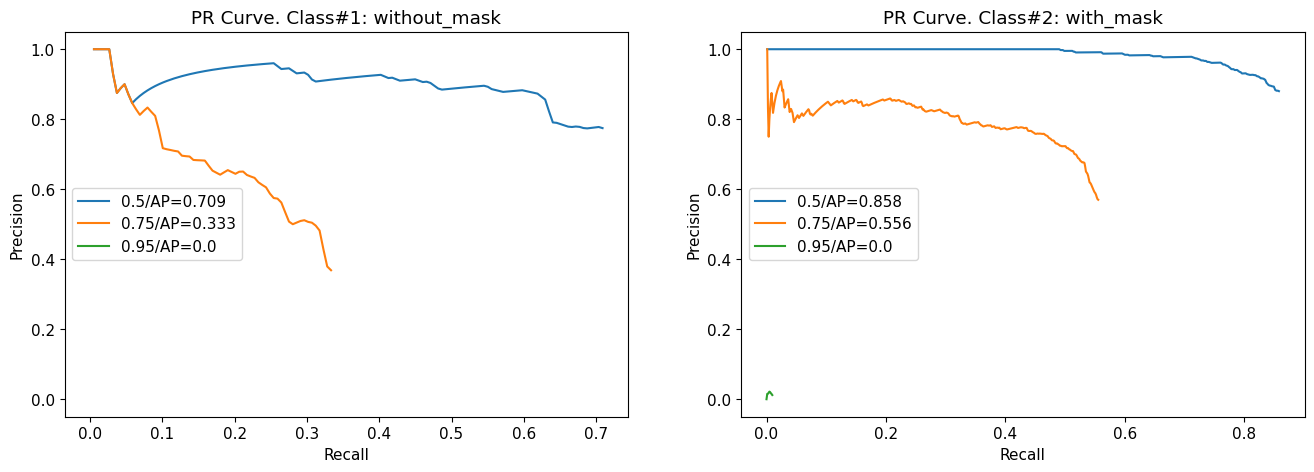

mAP50 = 0.7837


In [21]:
classes_unique = sorted(df['label'].unique())
classes_decoder = dataset.__dict__['dataset'].__dict__['classes']

fig,axe = plt.subplots(1,len(classes_unique),figsize=(16,5))
mAP = []
for n,label in enumerate(classes_unique):
    print(n,label)
    aps = []
    for threshold in [0.5, 0.75, 0.95]:
        dfs = df[(df['threshold']==threshold) & (df['label']==label)].sort_values(['score'], ascending=False)
        dfs['cum TP'] = dfs['TP'].cumsum()
        dfs['cum FP'] = dfs['FP'].cumsum()
        dfs['precision'] = dfs['cum TP'] / (dfs['cum TP'] + dfs['cum FP'])
        GT = dfs.groupby('id')['GT'].mean().sum()
        dfs['recall'] = dfs['cum TP'] / GT
        #display(dfs.head())
        AP = get_AP(dfs['precision'].values, dfs['recall'].values)
        
        sns.lineplot(data=dfs, x='recall', y='precision', label = f"{threshold}/AP={round(AP,3)}", ax=axe[n], errorbar=None).set(
            xlabel='Recall', 
            ylabel='Precision', 
            title=f'PR Curve. Class#{label}: {classes_decoder[label]}')
        axe[n].legend(loc='center left')

        aps.append(AP)

    class_AP = round(np.mean(aps),3)
    mAP.append(aps[0])
    #a[n].text(0.1,0.8, f'AP_cl{label}={class_AP}', fontsize=14, color='red')
plt.show()

print(f"mAP50 = {round(np.mean(mAP),4)}")